In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

file_path = 'ratings_Electronics.csv'
data = pd.read_csv(file_path, names=['userId', 'productId', 'rating', 'timestamp'])

print("Missing Values:", data.isnull().sum())


user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['user'] = user_encoder.fit_transform(data['userId'])
data['product'] = product_encoder.fit_transform(data['productId'])

X = data[['user', 'product']].values
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Missing Values: userId       0
productId    0
rating       1
timestamp    1
dtype: int64


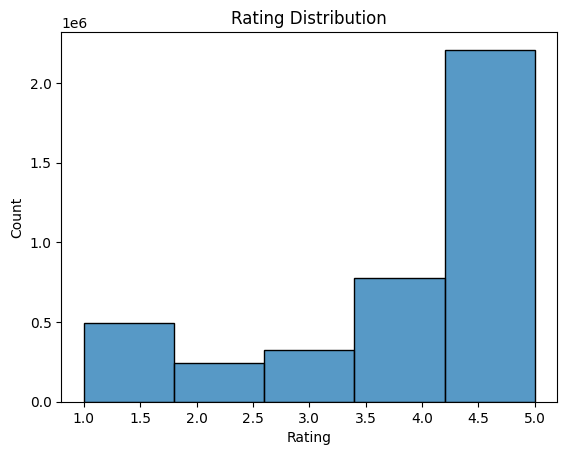

<ipython-input-12-c043613d16bf>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_active_users.index, y=most_active_users.values, palette='viridis')


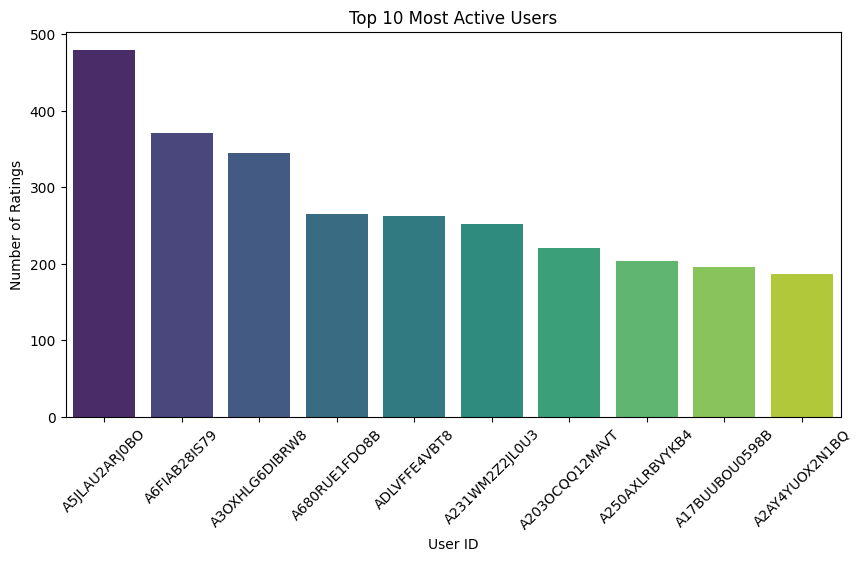

<ipython-input-12-c043613d16bf>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_rated_products.index, y=most_rated_products.values, palette='viridis')


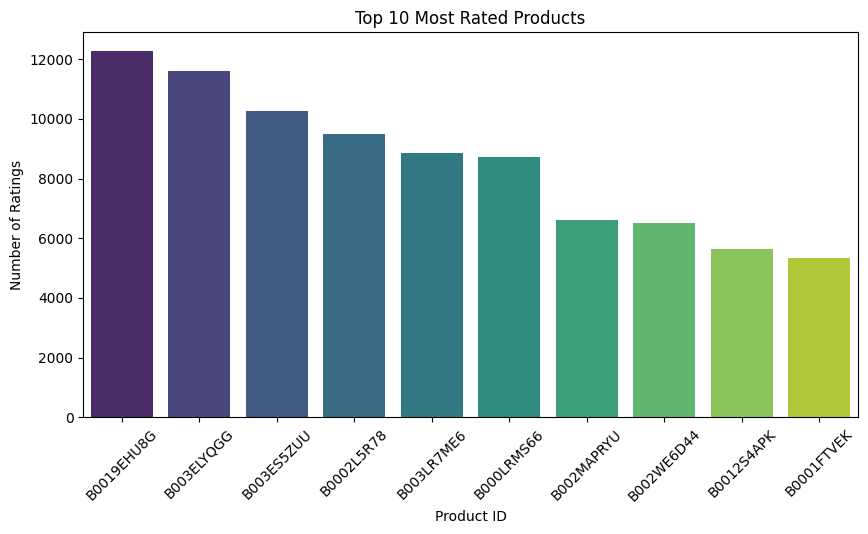

In [ ]:

sns.histplot(data['rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


most_active_users = data['userId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=most_active_users.index, y=most_active_users.values, palette='viridis')
plt.title('Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


most_rated_products = data['productId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=most_rated_products.index, y=most_rated_products.values, palette='viridis')
plt.title('Top 10 Most Rated Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


In [ ]:
n_users = data['user'].nunique()
n_products = data['product'].nunique()


In [ ]:
n_products

476002

In [7]:


n_users = data['user'].nunique()
n_products = data['product'].nunique()
embedding_dim = 16


user_input = Input(shape=(1,), name='user_input')
product_input = Input(shape=(1,), name='product_input')


user_embedding = Embedding(
    input_dim=n_users,
    output_dim=embedding_dim,
    input_length=1,
    name='user_embedding',
    embeddings_regularizer=l2(0.01)
)(user_input)

product_embedding = Embedding(
    input_dim=n_products,
    output_dim=embedding_dim,
    input_length=1,
    name='product_embedding',
    embeddings_regularizer=l2(0.01)
)(product_input)


user_flatten = Flatten()(user_embedding)
product_flatten = Flatten()(product_embedding)

concat = Concatenate()([user_flatten, product_flatten])


dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concat)
batch_norm1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.4)(batch_norm1)

dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
batch_norm2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.4)(batch_norm2)

output = Dense(1, name='output')(dropout2)


model = Model(inputs=[user_input, product_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.01), loss=Huber())


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)


history = model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)


loss = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")

Missing Values: userId       0
productId    0
rating       0
timestamp    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 223s 11ms/step - loss: 1.4233 - val_loss: 0.6703 - learning_rate: 0.0100
Epoch 2/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 255s 11ms/step - loss: 0.6677 - val_loss: 0.6698 - learning_rate: 0.0100
Epoch 3/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 262s 11ms/step - loss: 0.6678 - val_loss: 0.6696 - learning_rate: 0.0100
Epoch 4/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 262s 11ms/step - loss: 0.6681 - val_loss: 0.6687 - learning_rate: 0.0100
Epoch 5/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 261s 11ms/step - loss: 0.6679 - val_loss: 0.6686 - learning_rate: 0.0100
Epoch 6/20
19558/19562 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6679
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 262s 11ms/step - loss: 0.6679 - val_loss: 0.6690 - learning_rate: 0.0100
Epoch 7/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 264s 11ms/step - loss: 0.6397 - val_loss: 0.6421 - learning_rate: 0.0050
Epoch 8/20
19562/19562 ━━━━━━━━━━━━━━━━━━━━ 2

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict([X_test[:, 0], X_test[:, 1]])
y_pred = y_pred.flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



24452/24452 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
Root Mean Squared Error (RMSE): 1.0390


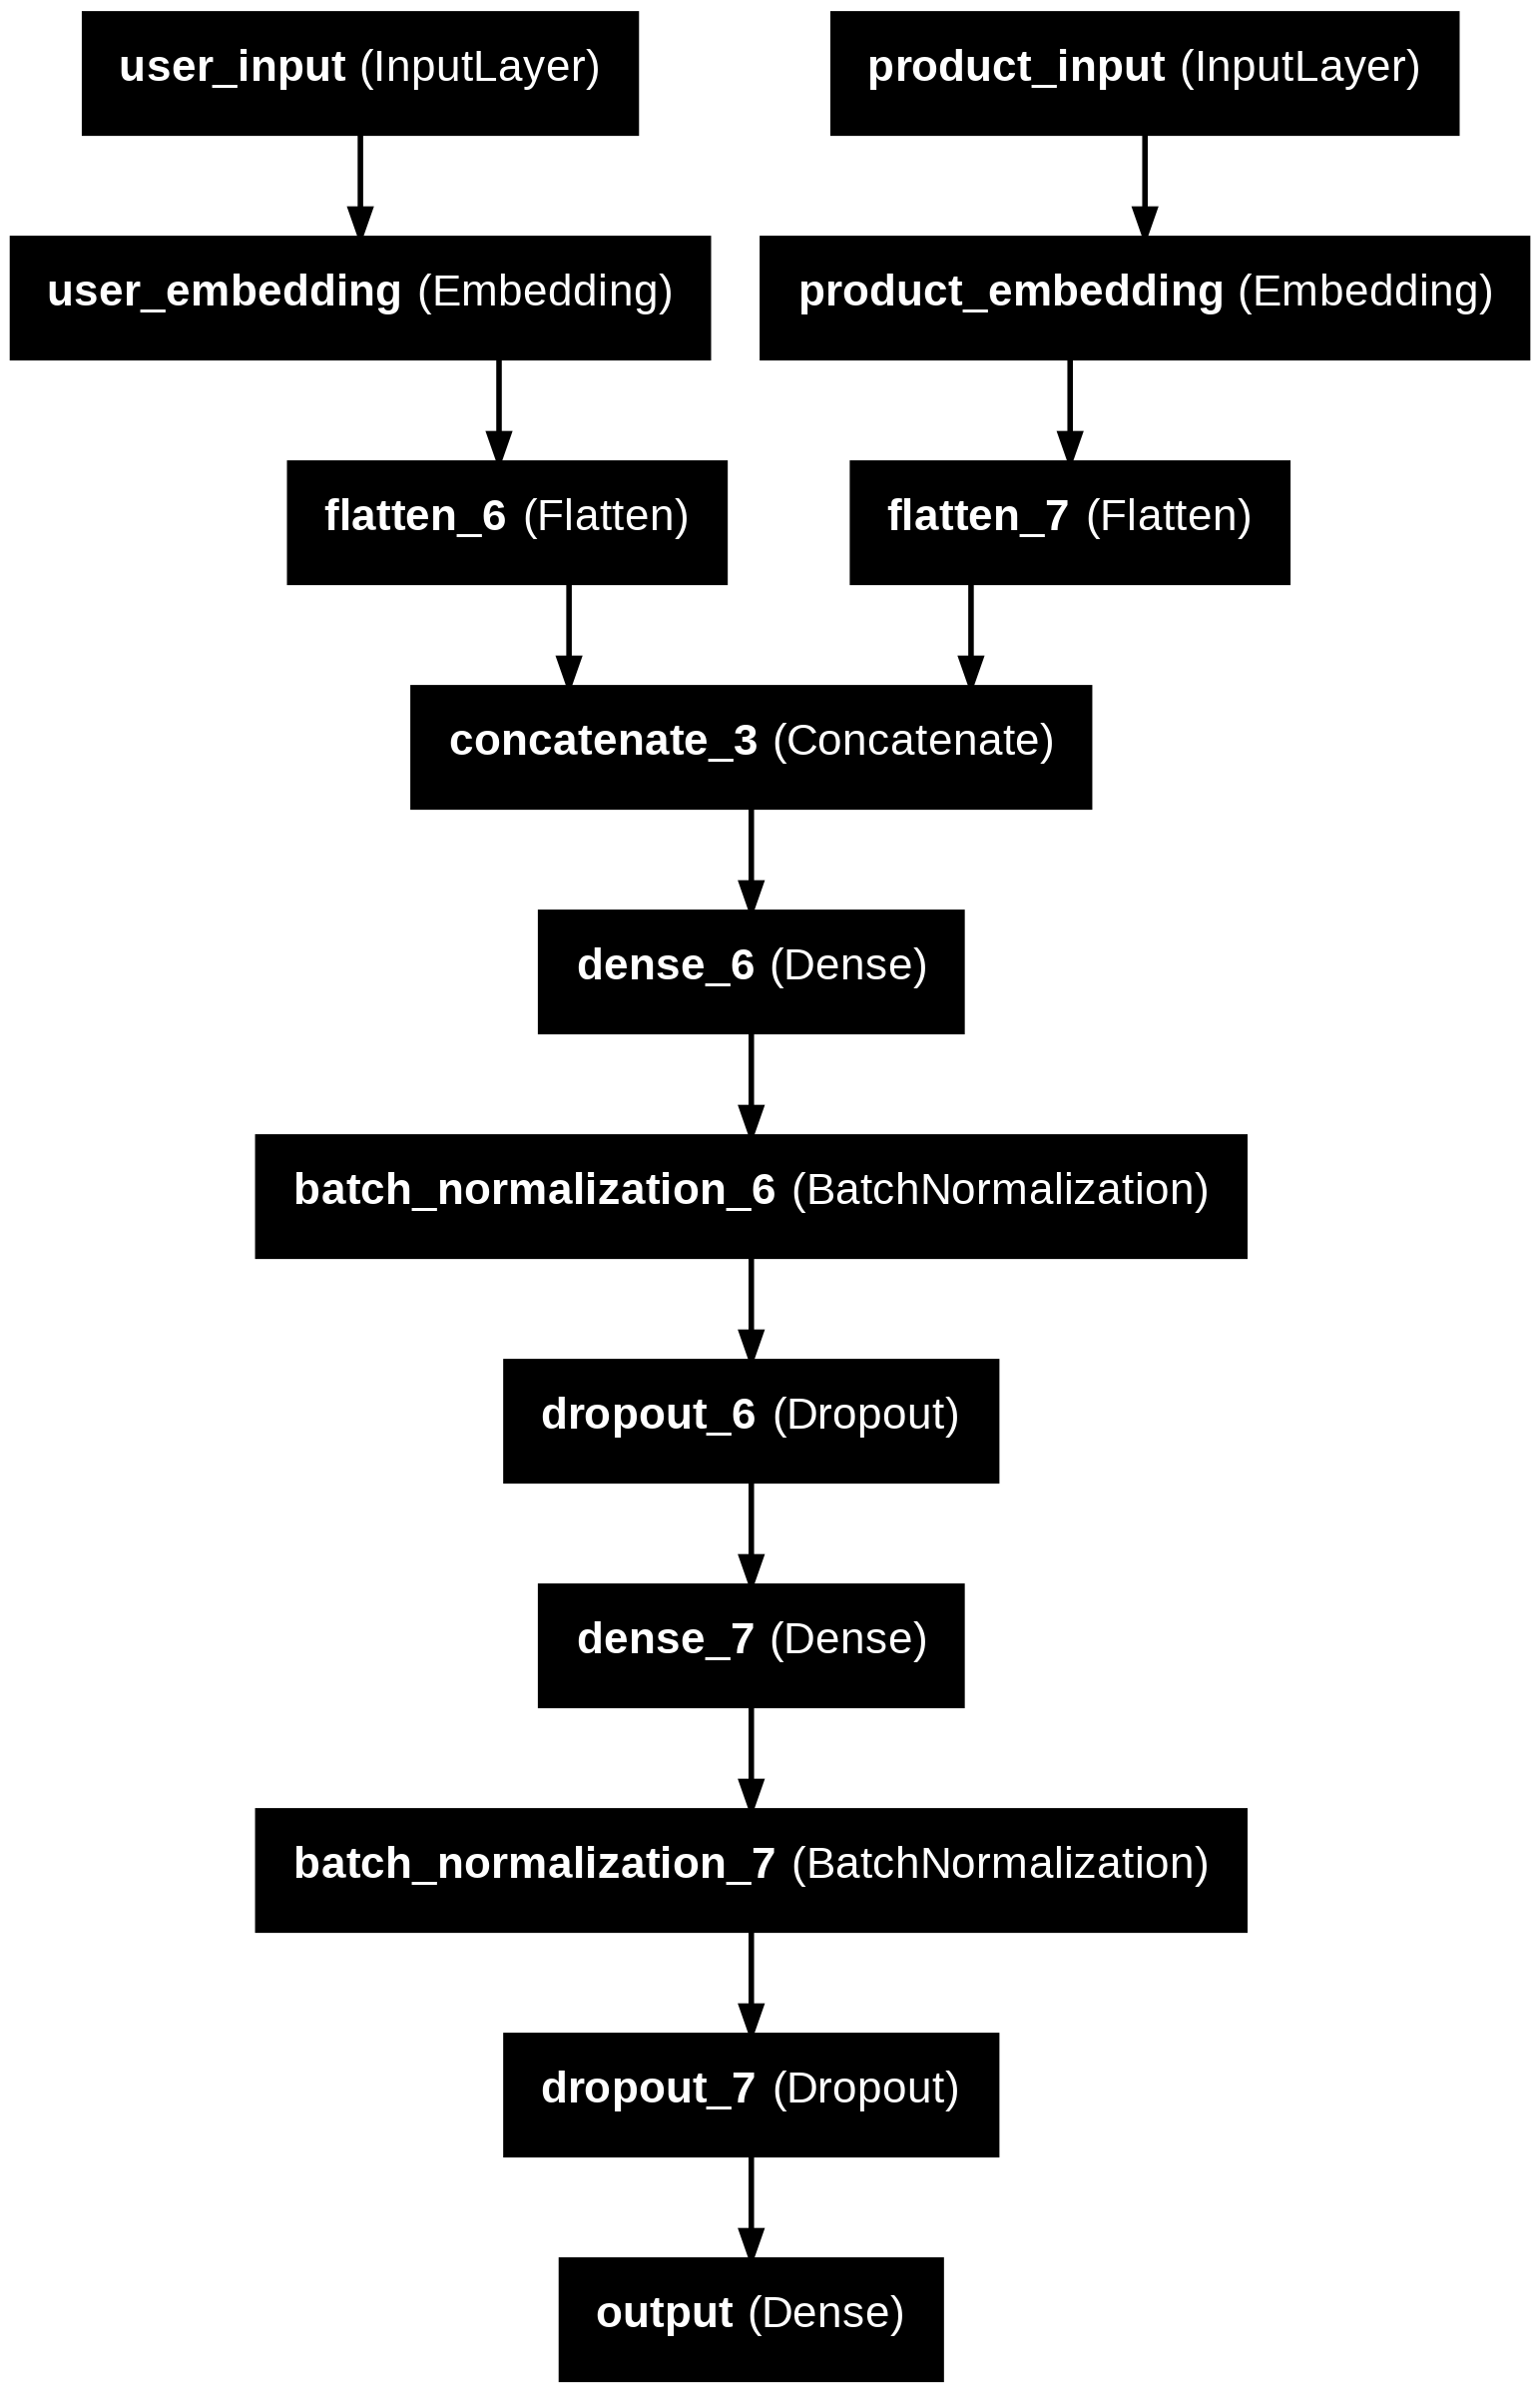

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='plot.png', show_layer_names=True)

In [16]:

def recommend_products_with_ratings(user_original_id, input_product_id=None, top_n=5):

    try:
        user_idx = user_encoder.transform([user_original_id])[0]
    except ValueError:
        raise ValueError(f"User ID '{user_original_id}' not found in training data.")


    all_products = np.arange(n_products)
    scores = model.predict([np.full(n_products, user_idx), all_products]).flatten()


    if input_product_id:
        try:
            product_idx = product_encoder.transform([input_product_id])[0]
            scores[product_idx] = -np.inf
        except ValueError:
            print(f"Product ID '{input_product_id}' not found in training data.")


    top_product_indices = np.argsort(-scores)[:top_n]
    recommended_product_ids = [product_mapping[idx] for idx in top_product_indices]
    recommended_ratings = [scores[idx] for idx in top_product_indices]


    recommendations_with_ratings = list(zip(recommended_product_ids, recommended_ratings))
    return recommendations_with_ratings


user_to_recommend = 'AKM1MP6P0OYPR'
input_product_id = '0132793040'
top_n = 5

recommendations = recommend_products_with_ratings(user_to_recommend, input_product_id, top_n)
print(f"\nRecommendations for user {user_to_recommend} based on product {input_product_id}:")
for product_id, rating in recommendations:
    print(f"Product: {product_id}, Predicted Rating: {rating:.2f}")



11276/11276 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step

Recommendations for user AKM1MP6P0OYPR based on product 0132793040:
Product: B004RCDWCK, Predicted Rating: 4.41
Product: B004RCHX0W, Predicted Rating: 4.41
Product: B004RCHTMO, Predicted Rating: 4.41
Product: B004RCHSOS, Predicted Rating: 4.41
Product: B004RCFORQ, Predicted Rating: 4.41
